In [1]:
from datetime import datetime
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

## Agent class

In [2]:
class REINFORCE_Agent():
    def __init__(self, input_shape=(4,), num_actions=2, entropy_coef=0.1, gamma=0.99, pretrained=''):
        
        self.agent = self.nn_model(input_size=input_shape, action_dim=num_actions)

        self.input_shape = input_shape
        self.num_actions = num_actions

        if pretrained:
            self.continue_training(pretrained)

        self.optimizer = tf.keras.optimizers.RMSprop()
        self.entropy_coef = entropy_coef
        self.gamma = gamma

    def nn_model(self, input_size, action_dim):
        
        input_layer = Input(shape=input_size)
        x = Dense(128, activation='tanh')(input_layer)
        x = Dense(64, activation='tanh')(x)
        x = Dense(16, activation='tanh')(x)
        output_layer = Dense(action_dim, activation='linear')(x)
        
        model = Model(input_layer, outputs = output_layer)
        return model
    
    def get_action(self, observation):

        observation = observation.reshape(1,-1)
        policy_logits = self.agent.predict_on_batch(observation)
        
        return int(tf.random.categorical(policy_logits, 1))
    
    def get_discounted_reward(self, reward_list):
        
        discounted_reward = 0
        discounted_reward_list = []
        reward_list.reverse()
        
        for each_reward in reward_list:
            discounted_reward = each_reward + self.gamma * discounted_reward
            discounted_reward_list.append(discounted_reward)
        discounted_reward_list.reverse()

        return tf.reshape(tf.convert_to_tensor(discounted_reward_list), (-1,1))
    
    def learn(self, obs_arr, action_arr, reward_list):

        cumulative_reward_arr = self.get_discounted_reward(reward_list)
        
        with tf.GradientTape() as tape:
            
            action_logits = self.agent(obs_arr, training=True)

            log_prob = tf.nn.log_softmax(action_logits)
            log_probs_for_chosen_actions = tf.reduce_sum(action_arr*log_prob, axis=1)
            log_probs_for_chosen_actions = tf.reshape(log_probs_for_chosen_actions, (-1,1))

            entropy = -1*tf.reduce_sum(tf.nn.softmax(action_logits) * log_prob, axis=1)

            obj = tf.reduce_mean(cumulative_reward_arr*log_probs_for_chosen_actions)
            entropy_term = self.entropy_coef*tf.reduce_mean(entropy)

            # Minimizing negative objective and entropy (increasing entropy ensures exploration.)
            loss = (-1)*(obj + entropy_term)
        
        grads = tape.gradient(loss, self.agent.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.agent.trainable_variables))

    def save_model(self, mdir):
        self.agent.save_weights(mdir)

    def continue_training(self, mdir):
        self.agent.load_weights(mdir)


## Environment Interaction

- `rollout` : plays an episode.

In [3]:
def rollout(env, agent):

    action_num = env.action_space.n
    one_hot_action = np.eye(action_num)

    obs_list, action_list, reward_list = [], [], []

    done, episode_reward = False, 0
    observation, _ = env.reset()

    while not done:
        action = agent.get_action(observation)
        next_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        obs_list.append(observation)
        action_list.append(one_hot_action[action])
        reward_list.append(0.1*reward)
        episode_reward += reward

        observation = next_observation

    return np.array(obs_list), np.array(action_list), reward_list, episode_reward

In [4]:
def train(env, agent, num_episodes, index:int=0):

    agent_name = 'REINFORCE'
    if not os.path.exists(agent_name):
        os.makedirs(agent_name)
    
    fig_path = agent_name+'/figs/'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
        
    reward_list = []

    for episode in range(num_episodes):
        obs_arr, action_arr, reward_arr, episode_reward = rollout(env, agent)
        reward_list.append(episode_reward)

        agent.learn(obs_arr, action_arr, reward_arr)

        if episode % 50 == 0:
            print (f"Episode#:{episode+1} reward:{episode_reward}")

    agent.save_model(os.path.join(agent_name + '/' + agent_name + '_' + str(index)))

    x_axis = np.arange(1, num_episodes+1)
    plt.figure(figsize=[3,3], dpi=300)
    plt.title(agent_name, fontsize=9)
    plt.plot(x_axis, reward_list, 'b-', linewidth=.5)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel('Total Rewards', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)
    plt.savefig(fig_path+agent_name+'_'+str(index)+'.png', bbox_inches='tight')
    plt.close()

    return reward_list

In [5]:
num_episodes=400
repeats = 5
reward_array = np.zeros((repeats, num_episodes))

Repeat#: 1


2023-06-06 01:00:49.852783: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Episode#:1 reward:20.0
Episode#:51 reward:78.0
Episode#:101 reward:70.0
Episode#:151 reward:75.0
Episode#:201 reward:168.0
Episode#:251 reward:199.0
Episode#:301 reward:164.0
Episode#:351 reward:275.0
Repeat#: 2
Episode#:1 reward:21.0
Episode#:51 reward:43.0
Episode#:101 reward:129.0
Episode#:151 reward:137.0
Episode#:201 reward:104.0
Episode#:251 reward:72.0
Episode#:301 reward:51.0
Episode#:351 reward:343.0
Repeat#: 3
Episode#:1 reward:17.0
Episode#:51 reward:83.0
Episode#:101 reward:142.0
Episode#:151 reward:45.0
Episode#:201 reward:19.0
Episode#:251 reward:404.0
Episode#:301 reward:59.0
Episode#:351 reward:52.0
Repeat#: 4
Episode#:1 reward:20.0
Episode#:51 reward:97.0
Episode#:101 reward:101.0
Episode#:151 reward:188.0
Episode#:201 reward:306.0
Episode#:251 reward:500.0
Episode#:301 reward:155.0
Episode#:351 reward:190.0
Repeat#: 5
Episode#:1 reward:10.0
Episode#:51 reward:83.0
Episode#:101 reward:135.0
Episode#:151 reward:35.0
Episode#:201 reward:40.0
Episode#:251 reward:44.0
Epis

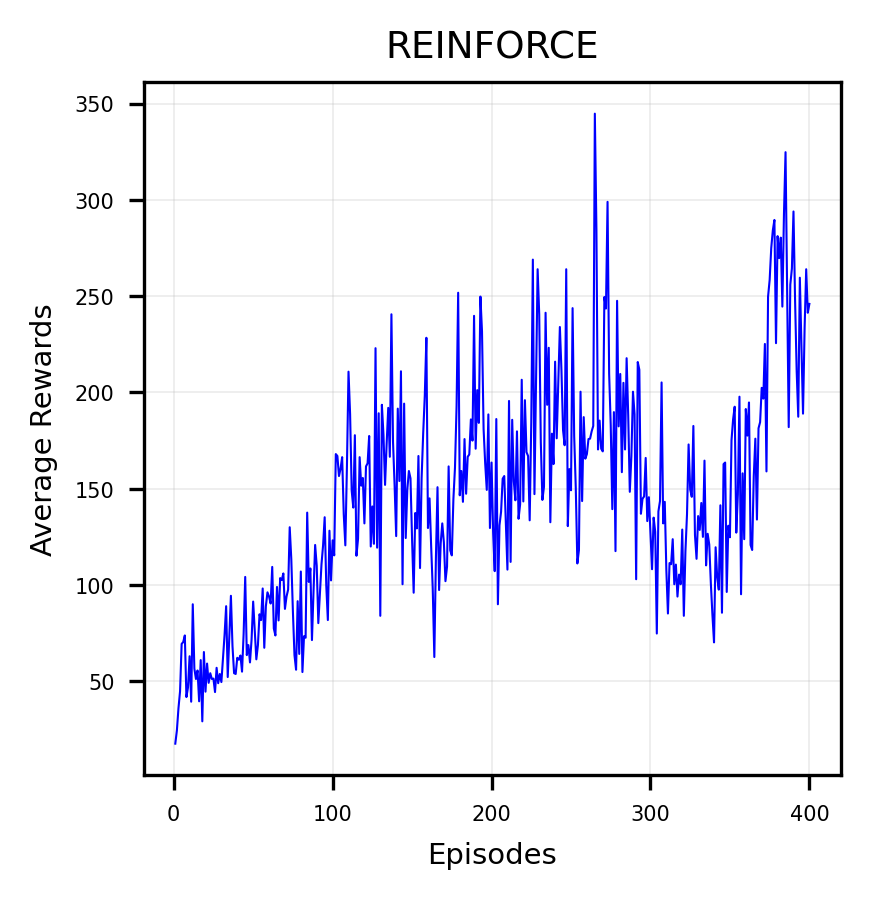

In [6]:
for i in range(repeats):
    print(f"Repeat#: {i+1}")
    env = gym.make('CartPole-v1')
    agent = REINFORCE_Agent(input_shape=env.observation_space.shape,
                            num_actions=env.action_space.n,
                            entropy_coef=0.1,
                            gamma=0.99,
                            pretrained='')
    
    reward_list = train(env, agent, num_episodes, index=i)
    reward_array[i] = reward_list

mean_reward_array = np.mean(reward_array, axis=0)

agent_name = 'REINFORCE'
fig_path = agent_name + '/figs/'

x_axis = np.arange(1, num_episodes+1)
plt.figure(figsize=[3,3], dpi=300)
plt.title(agent_name, fontsize=9)
plt.plot(x_axis, mean_reward_array, 'b-', linewidth=.5)
plt.xlabel('Episodes', fontsize=7)
plt.ylabel('Average Rewards', fontsize=7)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.grid(linewidth=.1)
plt.savefig(fig_path+agent_name+'_average_'+str(repeats)+'.png', bbox_inches='tight')
plt.show()
plt.close()